In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from collections import Counter
import seaborn as sns
from nltk import punkt, wordnet, word_tokenize
from nltk.stem import PorterStemmer,  WordNetLemmatizer 
from textblob import TextBlob
import collections
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
import en_core_web_sm
from textstat import flesch_reading_ease
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [65]:
df = pd.read_csv(r'Cell_phone_and_accesory_reviews.csv')

In [66]:
df.head()
df.shape

(85845, 13)

In [67]:
mask = df['summary'].str.len() > 0
df = df.loc[mask]
df.shape

(85844, 13)

Next we will begin feature engineering

In [68]:
df['summary_char_count'] = df['summary'].str.len()
df['review_char_count']= df['reviewText'].str.len()
df['review_word_count'] = df['reviewText'].str.split().map(lambda x: len(x))
df['summary_word_count'] = df['summary'].str.split().map(lambda x: len(x))

In [75]:
corpus=[]
split_df= df['reviewText'].str.split()

new=split_df.values.tolist()

corpus=[word.lower() for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

In [76]:
def stopword(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
    return top

In [79]:
stopwords_reviews = stopword(df['reviewText'])
print(stopwords_reviews)

[('the', 248502), ('and', 141073), ('to', 125954), ('a', 122654), ('it', 115435), ('is', 88352), ('my', 69149), ('for', 66274), ('of', 61715), ('this', 57481)]


In [102]:
counts=Counter(corpus)
most=counts.most_common()

x,y = [],[]
for word,count in most[:70]:
    if (word not in stop):
        x.append(word)
        y.append(count)
print(x)

['phone', 'case', 'one', 'like', 'great', 'would', 'good', 'screen', 'get', 'use', 'it.', 'love', 'really', 'battery', 'product', 'works', 'phone.', 'iphone']


In [104]:
def sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiments_reviews'] = df['reviewText'].apply(lambda x : sentiment(x))
df['sentiment_summary'] = df['summary'].apply(lambda x : sentiment(x))

In [106]:
def rating(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'
    
df['reviews_rating_cat']= df['sentiments_reviews'].map(lambda x: rating(x))
df['summary_rating_cat']= df['sentiment_summary'].map(lambda x: rating(x))

In [108]:
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    ss = sid.polarity_scores(sent)# Polarity score returns dictionary
    return np.argmax(list(ss.values())[:-1])

df['vader_score_review'] =df['reviewText'].map(lambda x: get_vader_score(x))
df['vader_score_summary'] =df['summary'].map(lambda x: get_vader_score(x))

In [122]:
df['vader_score_review'] = df['vader_score_review'].replace({0:'neg',1:'neu',2:'pos'})
df['vader_score_summary'] = df['vader_score_summary'].replace({0:'neg',1:'neu',2:'pos'})

In [109]:
df['review_ease_of_reading'] = df['reviewText'].apply(lambda x: flesch_reading_ease(x))
df['summar_ease_of_reading'] = df['summary'].apply(lambda x: flesch_reading_ease(x))

In [129]:
df_attributes

,class,summary_char_count,review_char_count,review_word_count,summary_word_count,sentiments_reviews,sentiment_summary,reviews_rating_cat,summary_rating_cat,vader_score_review,vader_score_summary,review_ease_of_reading,summar_ease_of_reading
0,1,13,101,21,2,0.570000,0.800,pos,pos,neu,pos,103.12,77.91
1,0,15,215,42,4,0.090741,0.000,pos,neu,neu,neu,94.66,118.18
2,1,17,109,25,4,0.433333,1.000,pos,pos,neu,neg,88.40,118.18
3,0,25,235,43,5,-0.062500,0.000,neg,neu,neu,neu,82.34,100.24
4,1,6,108,23,1,0.086667,1.000,pos,pos,neu,pos,81.97,121.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85840,1,5,124,23,1,0.308939,0.000,pos,neu,neu,neu,105.96,121.22
85841,1,26,255,50,5,0.138000,0.600,pos,pos,neu,neu,101.09,100.24
85842,1,10,33,5,2,0.475000,0.000,pos,neu,pos,neu,49.48,120.21
85843,1,57,140,27,10,0.625000,0.425,pos,pos,neu,neu,60.99,61.33


In [124]:
df_attributes = df[['class', 'summary_char_count', 'review_char_count',
       'review_word_count', 'summary_word_count', 'sentiments_reviews',
       'sentiment_summary', 'reviews_rating_cat', 'summary_rating_cat',
       'vader_score_review', 'vader_score_summary', 'review_ease_of_reading',
       'summar_ease_of_reading']]

In [159]:
df_attributes_num =  df[['summary_char_count', 'review_char_count',
       'review_word_count', 'summary_word_count','sentiments_reviews',
       'sentiment_summary','review_ease_of_reading','summar_ease_of_reading']]
scale  = StandardScaler()
df_scaled = scale.fit_transform(df_attributes_num)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = ['summary_char_count', 'review_char_count',
       'review_word_count', 'summary_word_count','sentiments_reviews',
       'sentiment_summary','review_ease_of_reading','summar_ease_of_reading']

dfo = df[['reviews_rating_cat', 'summary_rating_cat','vader_score_review', 'vader_score_summary']]

df2 = pd.concat([df_scaled, pd.get_dummies(dfo)], axis=1)
df2 = pd.concat([df2, df['class']], axis=1)

In [160]:
df2.isnull().sum()

summary_char_count         1
review_char_count          1
review_word_count          1
summary_word_count         1
sentiments_reviews         1
sentiment_summary          1
review_ease_of_reading     1
summar_ease_of_reading     1
reviews_rating_cat_neg     1
reviews_rating_cat_neu     1
reviews_rating_cat_pos     1
summary_rating_cat_neg     1
summary_rating_cat_neu     1
summary_rating_cat_pos     1
vader_score_review_neg     1
vader_score_review_neu     1
vader_score_review_pos     1
vader_score_summary_neg    1
vader_score_summary_neu    1
vader_score_summary_pos    1
class                      1
dtype: int64

In [161]:
df2.dropna(inplace=True)

In [162]:
df2.to_pickle(r'C:\Users\User\Spam_reviews_preprocessed.pkl')

In [163]:
X = df2.drop(columns = ['class'])
y = df2['class']

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Model Selection

Since the dependent variable is a yes/no answer. We will need to use models that are good at categorization. Specifically we want models that are good at binary classification. In this case we will use Naive Bayes, Random Forest, and Logistic Regression

In [169]:
from sklearn.linear_model import LogisticRegression
Logreg = LogisticRegression(penalty = 'l2', C = .1,random_state = 40)
Logreg.fit(X_train,y_train)
y_pred_lr = Logreg.predict(X_test)

In [170]:
from sklearn.metrics import confusion_matrix

cnf_matrix= confusion_matrix(y_test,y_pred_lr)
print(cnf_matrix)
Accuracy_lr=Logreg.score(X_test,y_test)

print(Accuracy_lr)

[[ 3946  3584]
 [ 1177 17046]]
0.8151283345629635


In [172]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_lr, average='binary')
print('precision:', precision )
print('recall:',recall)
print('fscore:', fscore)
print('support:',support)

precision: 0.8262724188075617
recall: 0.9354112934204027
fscore: 0.877461199907343
support: None


In [185]:

from sklearn.model_selection import cross_val_score

cv_scores_test= cross_val_score(Logreg,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(Logreg,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_log_test= cv_scores_test.mean()
cv_scores_log_train= cv_scores_train.mean()
cv_scores_std_log= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_log_test))
print ('Mean cross validation train score: ' +str(cv_scores_log_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_log))

[0.84346309 0.83468322 0.82538397 0.84539039 0.83804327]
Mean cross validation test score: 0.8373927882834531
Mean cross validation train score: 0.8367122224005843
Standard deviation in cv scores: 0.007110371573041446


In [183]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train,y_train)
y_pred_NB = model.predict(X_test)

In [177]:
cnf_matrix= confusion_matrix(y_test,y_pred_NB)
print(cnf_matrix)
Accuracy_NB= model.score(X_test,y_test)

print(Accuracy_NB)

[[ 4166  3364]
 [ 1881 16342]]
0.7963344076418282


In [178]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_NB, average='binary')
print('precision:', precision )
print('recall:',recall)
print('fscore:', fscore)
print('support:',support)

precision: 0.8292905713995737
recall: 0.8967787960269988
fscore: 0.861715310184819
support: None


In [187]:
cv_scores_test= cross_val_score(model,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(model,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_NB_test= cv_scores_test.mean()
cv_scores_NB_train= cv_scores_train.mean()
cv_scores_std_NB =  cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_NB_test))
print ('Mean cross validation train score: ' +str(cv_scores_NB_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_NB))

[0.83304869 0.82379299 0.8164569  0.83500311 0.82954361]
Mean cross validation test score: 0.8275690582837214
Mean cross validation train score: 0.8295083604044435
Standard deviation in cv scores: 0.006736901074798521


In [179]:

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(bootstrap=True,n_estimators=20,criterion='entropy', random_state =1)
rf.fit(X_train, y_train)
y_predict_rf = rf.predict(X_test)

In [180]:
cnf_matrix = confusion_matrix(y_test, y_predict_rf)
print(cnf_matrix)
Accuracy_rf=rf.score(X_test,y_test)
print(Accuracy_rf)

[[ 4114  3416]
 [ 1923 16300]]
0.7926843474546654


In [181]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_predict_rf, average='binary')
print('precision:', precision )
print('recall:',recall)
print('fscore:', fscore)
print('support:',support)

precision: 0.826739703793873
recall: 0.8944740163529605
fscore: 0.8592740978939878
support: None


In [186]:
cv_scores_test= cross_val_score(rf,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(rf,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train= cv_scores_train.mean()
cv_scores_std_rf= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_rf))

[0.82085932 0.80894401 0.80279896 0.8188758  0.81521016]
Mean cross validation test score: 0.8133376483440632
Mean cross validation train score: 0.8135579322931774
Standard deviation in cv scores: 0.006650126926531699


In [188]:
myLabels = ['Random Forest','Naive Bayes','Logistic Regression']
Accuracy_score = [Accuracy_rf, Accuracy_NB, Accuracy_lr]
score_test = [cv_scores_rf_test, cv_scores_NB_test, cv_scores_log_test]
score_train= [ cv_scores_rf_train, cv_scores_NB_train, cv_scores_log_train]
score_tab_accuracy = pd.DataFrame(list(zip(myLabels, Accuracy_score)), 
               columns =['Algorithm', 'Model accuracy score']) 

print(score_tab_accuracy)
roc_score = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
                         columns =['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score' ]) 
roc_score

             Algorithm  Model accuracy score
0        Random Forest              0.792684
1          Naive Bayes              0.796334
2  Logistic Regression              0.815128


,Algorithm,ROC-AUC train score,ROC-AUC test score
0,Random Forest,0.813558,0.813338
1,Naive Bayes,0.829508,0.827569
2,Logistic Regression,0.836712,0.837393


As we can see with just simple implementation of the machine learning models we are able to receive about an 80% ROC test and train score

Now we will try to get our models to be more accurate with hyperparameter tuning

In [190]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(max_features='auto',random_state=1, n_jobs=-1)

param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10], "min_samples_split" : [2,8,16], "n_estimators": [10,15,20]}

rs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1)

rs = rs.fit(X_train, y_train)

print(rs.best_estimator_) 
print(rs.best_score_)

RandomForestClassifier(min_samples_leaf=10, n_estimators=20, n_jobs=-1,
                       random_state=1)
0.811266433682809


In [191]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(bootstrap=True,n_estimators=20,criterion='entropy',min_samples_leaf =10, n_jobs =-1, random_state =1)
rf.fit(X_train, y_train)
y_predict_rf = rf.predict(X_test)

In [192]:
cnf_matrix = confusion_matrix(y_test, y_predict_rf)
print(cnf_matrix)
Accuracy_rf=rf.score(X_test,y_test)
print(Accuracy_rf)

[[ 3907  3623]
 [ 1153 17070]]
0.8145458781501185


In [193]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_predict_rf, average='binary')
print('precision:', precision )
print('recall:',recall)
print('fscore:', fscore)
print('support:',support)

precision: 0.8249166384767795
recall: 0.9367283103769961
fscore: 0.8772741288930004
support: None


In [194]:
cv_scores_test= cross_val_score(rf,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(rf,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train= cv_scores_train.mean()
cv_scores_std_rf= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_rf))

[0.84035518 0.83223831 0.82327216 0.83637104 0.83545374]
Mean cross validation test score: 0.8335380842651148
Mean cross validation train score: 0.8328390806479277
Standard deviation in cv scores: 0.005748855845281771


In [195]:

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
logreg = LogisticRegression(penalty = 'l2',random_state = 40)
rs3 = GridSearchCV(estimator= logreg,param_grid = param_grid, scoring= 'accuracy', cv=3, n_jobs =-1 )

rs3 = rs3.fit(X_train, y_train)
print(rs3.best_estimator_)
print(rs3.best_score_)

LogisticRegression(C=0.01, random_state=40)
0.8125977700116492


In [196]:
Logreg = LogisticRegression(penalty = 'l2', C = .01,random_state = 40)
Logreg.fit(X_train,y_train)
y_pred_lr = Logreg.predict(X_test)

In [197]:
cnf_matrix= confusion_matrix(y_test,y_pred_lr)
print(cnf_matrix)
Accuracy_lr=Logreg.score(X_test,y_test)

print(Accuracy_lr)

[[ 3943  3587]
 [ 1174 17049]]
0.8151283345629635


In [198]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_lr, average='binary')
print('precision:', precision )
print('recall:',recall)
print('fscore:', fscore)
print('support:',support)

precision: 0.8261775537894941
recall: 0.935575920539977
fscore: 0.8774801204354203
support: None


In [199]:
cv_scores_test= cross_val_score(Logreg,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(Logreg,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_log_test= cv_scores_test.mean()
cv_scores_log_train= cv_scores_train.mean()
cv_scores_std_log= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_log_test))
print ('Mean cross validation train score: ' +str(cv_scores_log_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_log))

[0.84301896 0.83446552 0.82396905 0.84421033 0.83693701]
Mean cross validation test score: 0.8365201765559037
Mean cross validation train score: 0.8363466573559941
Standard deviation in cv scores: 0.007256704457439789


In [201]:
param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}
rs4 = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=3, n_jobs=-1)
rs4 = rs4.fit(X_train, y_train)
print(rs4.best_estimator_)
print(rs4.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
GaussianNB(var_smoothing=0.08111308307896872)
0.8092694291895489


In [202]:
model = GaussianNB(var_smoothing=0.08111308307896872)
model.fit(X_train,y_train)
y_pred_NB = model.predict(X_test)

In [203]:
cnf_matrix= confusion_matrix(y_test,y_pred_NB)
print(cnf_matrix)
Accuracy_NB= model.score(X_test,y_test)

print(Accuracy_NB)

[[ 4044  3486]
 [ 1328 16895]]
0.8130703219042442


In [204]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_NB, average='binary')
print('precision:', precision )
print('recall:',recall)
print('fscore:', fscore)
print('support:',support)

precision: 0.8289583435552721
recall: 0.9271250617351698
fscore: 0.8752978965910267
support: None


In [205]:
cv_scores_test= cross_val_score(model,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(model,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_NB_test= cv_scores_test.mean()
cv_scores_NB_train= cv_scores_train.mean()
cv_scores_std_NB =  cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_NB_test))
print ('Mean cross validation train score: ' +str(cv_scores_NB_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_NB))

[0.8368995  0.82205062 0.81500555 0.83343975 0.83103289]
Mean cross validation test score: 0.827685661407459
Mean cross validation train score: 0.8321498746306297
Standard deviation in cv scores: 0.008021811615954954


In [207]:
myLabels = ['Random Forest','Naive Bayes','Logistic Regression']
Accuracy_score = [Accuracy_rf, Accuracy_NB, Accuracy_lr]
score_test = [cv_scores_rf_test, cv_scores_NB_test, cv_scores_log_test]
score_train= [ cv_scores_rf_train, cv_scores_NB_train, cv_scores_log_train]
score_tab_accuracy = pd.DataFrame(list(zip(myLabels, Accuracy_score)), 
               columns =['Algorithm', 'Model accuracy score']) 

print(score_tab_accuracy)
roc_score = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
                         columns =['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score' ]) 
roc_score

             Algorithm  Model accuracy score
0        Random Forest              0.814546
1          Naive Bayes              0.813070
2  Logistic Regression              0.815128


,Algorithm,ROC-AUC train score,ROC-AUC test score
0,Random Forest,0.832839,0.833538
1,Naive Bayes,0.832150,0.827686
2,Logistic Regression,0.836347,0.836520


feature importances and ROC curve

                 Features  Importance scores
0      summary_char_count           0.037849
1       review_char_count           0.051752
2       review_word_count           0.041855
3      summary_word_count           0.016615
4      sentiments_reviews           0.057021
5       sentiment_summary           0.030130
6  review_ease_of_reading           0.053326
7  summar_ease_of_reading           0.030049
8  reviews_rating_cat_neg           0.091455
9  reviews_rating_cat_neu           0.005899


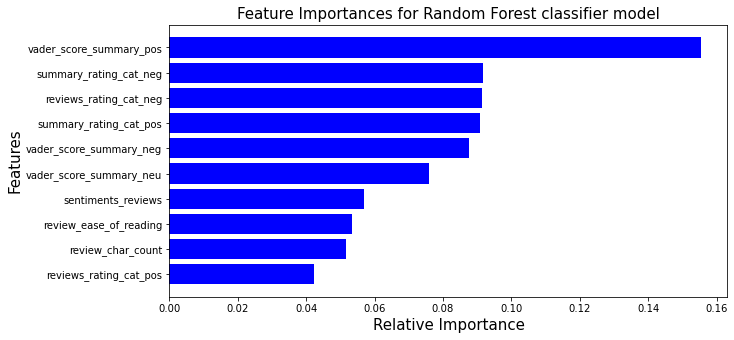

In [209]:
#Feature importances:

features = X
importances = list(rf.feature_importances_)
tab=pd.DataFrame(list(zip(X,importances)),columns =['Features', 'Importance scores']) 
print(tab[:10])
sorted_features =tab.sort_values(by=['Importance scores'], ascending=False)
#Visual comparison:
plt.figure(figsize=(10,5))
index = list(range(len(sorted_features[:10])))
_=plt.barh(index,sorted_features['Importance scores'][:10], align='center',color='b')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.yticks(index, sorted_features['Features'][:10])
plt.title('Feature Importances for Random Forest classifier model',fontsize=15)
plt.gca().invert_yaxis()
plt.savefig("29.png")
plt.show()

                   Features  Importance scores  Absolute_val
19  vader_score_summary_pos           1.532974      1.532974
17  vader_score_summary_neg          -1.521366      1.521366
10   reviews_rating_cat_pos           0.864210      0.864210
11   summary_rating_cat_neg          -0.840301      0.840301
8    reviews_rating_cat_neg          -0.829675      0.829675
16   vader_score_review_pos           0.701152      0.701152
13   summary_rating_cat_pos           0.610260      0.610260
15   vader_score_review_neu          -0.595297      0.595297
12   summary_rating_cat_neu           0.229671      0.229671
14   vader_score_review_neg          -0.106225      0.106225
5         sentiment_summary           0.071649      0.071649
0        summary_char_count           0.064591      0.064591
9    reviews_rating_cat_neu          -0.034905      0.034905
3        summary_word_count          -0.030425      0.030425
4        sentiments_reviews           0.027531      0.027531
2         review_word_co

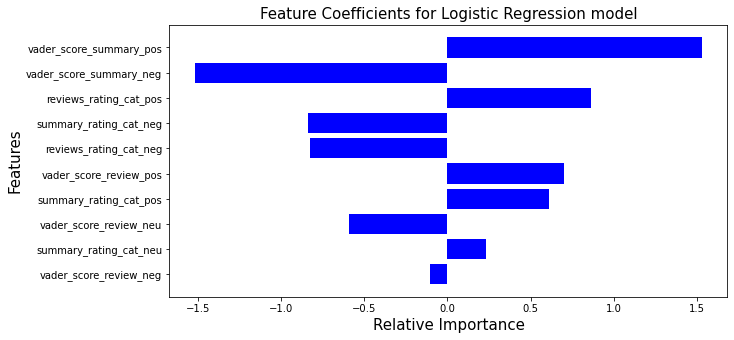

In [210]:
features = X
importances = Logreg.coef_
absolute_importances = abs(Logreg.coef_)
tab=pd.DataFrame(list(zip(X,importances[0], absolute_importances[0])),columns =['Features', 'Importance scores','Absolute_val']) 

sorted_features =tab.sort_values(by=['Absolute_val'], ascending=False)
print(sorted_features)
#Visual comparison:
plt.figure(figsize=(10,5))
index = list(range(len(sorted_features[:10])))
_=plt.barh(index,sorted_features['Importance scores'][:10], align='center',color='b')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.yticks(index, sorted_features['Features'][:10])
plt.title('Feature Coefficients for Logistic Regression model',fontsize=15)
plt.gca().invert_yaxis()
plt.savefig("29.png")
plt.show()

In [216]:
from sklearn.inspection import permutation_importance
features = X
imps = permutation_importance(model, X_test, y_test)

                   Features  Importance scores  Absolute_val
11   summary_rating_cat_neg           0.020867      0.020867
17  vader_score_summary_neg           0.020728      0.020728
8    reviews_rating_cat_neg           0.016185      0.016185
10   reviews_rating_cat_pos           0.013264      0.013264
19  vader_score_summary_pos           0.012434      0.012434
18  vader_score_summary_neu           0.005289      0.005289
13   summary_rating_cat_pos           0.003968      0.003968
9    reviews_rating_cat_neu           0.003106      0.003106
12   summary_rating_cat_neu           0.001709      0.001709
16   vader_score_review_pos           0.000551      0.000551
15   vader_score_review_neu           0.000544      0.000544
7    summar_ease_of_reading          -0.000466      0.000466
5         sentiment_summary          -0.000280      0.000280
2         review_word_count           0.000163      0.000163
4        sentiments_reviews          -0.000140      0.000140
6    review_ease_of_read

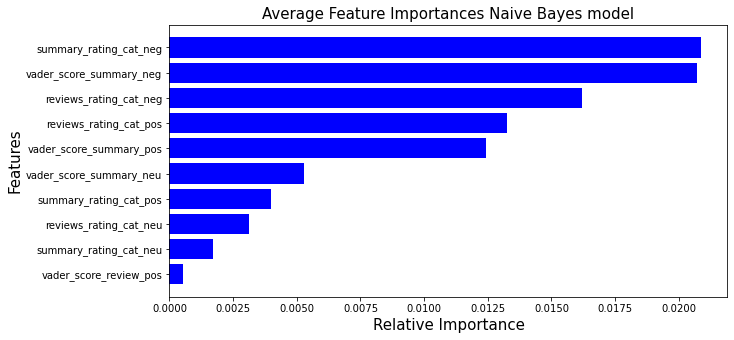

In [226]:
importances = imps.importances_mean
absolute_importances = abs(imps.importances_mean)
tab = pd.DataFrame(list(zip(X,importances, absolute_importances)), columns= ['Features', 'Importance scores','Absolute_val'])

sorted_features = tab.sort_values(by=['Absolute_val'], ascending=False)
print(sorted_features)

plt.figure(figsize=(10,5))
index = list(range(len(sorted_features[:10])))
_=plt.barh(index,sorted_features['Importance scores'][:10], align='center',color='b')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.yticks(index, sorted_features['Features'][:10])
plt.title('Average Feature Importances Naive Bayes model',fontsize=15)
plt.gca().invert_yaxis()
plt.savefig("29.png")
plt.show()


Random Forest roc score

In [227]:
#plot roc curves

from sklearn.metrics import auc, roc_curve, roc_auc_score
y_scores_rf = rf.predict_proba(X_test)
y_scores_rf = y_scores_rf[:,1]
auroc = roc_auc_score(y_test, y_scores_rf)
print("ROC-AUC Score:", auroc)

ROC-AUC Score: 0.8340022412317112


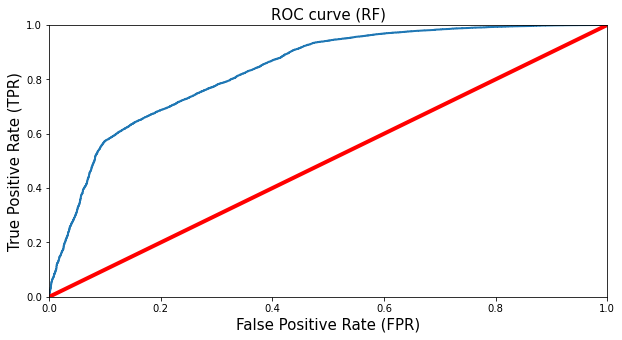

In [228]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_rf)
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title('ROC curve (RF)',fontsize=15)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.savefig("30.png")
plt.show()

In [230]:
y_scores_logreg = Logreg.predict_proba(X_test)
y_scores_logreg = y_scores_logreg[:,1]
auroc = roc_auc_score(y_test, y_scores_logreg)
print("ROC-AUC Score:", auroc)

ROC-AUC Score: 0.8370297988204127


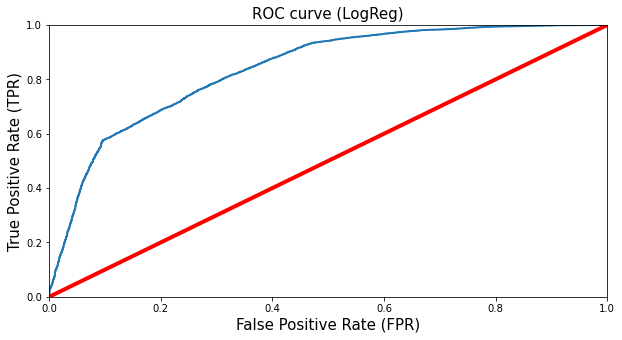

In [235]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_logreg)###logreg
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title('ROC curve (LogReg)',fontsize=15)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.savefig("30.png")
plt.show()

In [232]:
y_scores_NB = model.predict_proba(X_test)
y_scores_NB = y_scores_NB[:,1]
auroc = roc_auc_score(y_test, y_scores_NB)
print("ROC-AUC Score:", auroc)

ROC-AUC Score: 0.8330156882575972


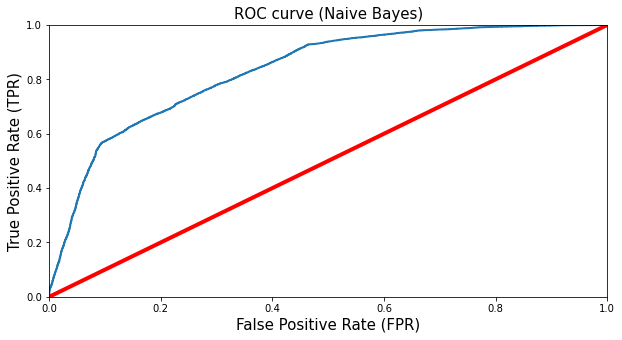

In [237]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_NB)###nb
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title('ROC curve (Naive Bayes)',fontsize=15)

plt.show()
plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.savefig("30.png")
plt.show()

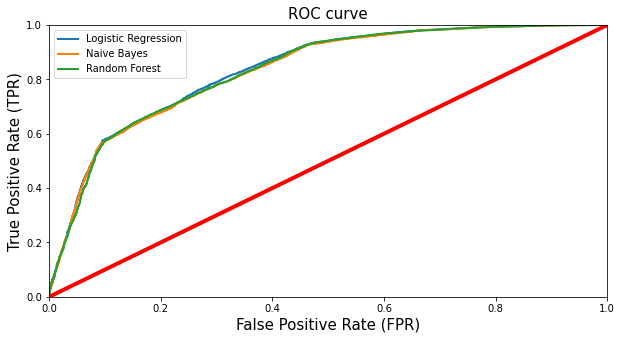

In [240]:
false_positive_rate1, true_positive_rate1, thresholds1 = roc_curve(y_test, y_scores_logreg)###logreg
false_positive_rate2, true_positive_rate2, thresholds2 = roc_curve(y_test, y_scores_NB)
false_positive_rate3, true_positive_rate3, thresholds3 = roc_curve(y_test, y_scores_rf)
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate1, true_positive_rate1, linewidth=2, label='Logistic Regression')
    plt.plot(false_positive_rate2, true_positive_rate2, linewidth=2, label='Naive Bayes')
    plt.plot(false_positive_rate3, true_positive_rate3, linewidth=2, label='Random Forest')
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=15)
    plt.ylabel('True Positive Rate (TPR)', fontsize=15)
    plt.title('ROC curve',fontsize=15)
    plt.legend()

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.savefig("30.png")
plt.show()

In [241]:
#add precision recall f1-score in a graph
precision_n, recall_n, fscore_n, support_n = precision_recall_fscore_support(y_test, y_pred_NB, average='binary')
precision_rf, recall_rf, fscore_rf, support_rf = precision_recall_fscore_support(y_test, y_predict_rf, average='binary')
precision_lr, recall_lr, fscore_lr, support_lr = precision_recall_fscore_support(y_test, y_pred_lr, average='binary')

In [243]:

myLabels = ['Random Forest','Naive Bayes','Logistic Regression']
precision_score = [precision_rf,precision_n,precision_lr]
recall_score = [recall_rf,recall_n,recall_lr]
fscore = [fscore_rf,fscore_n,fscore_lr]

df_scores = pd.DataFrame(list(zip(myLabels, precision_score, recall_score, fscore)),columns = ['Algorithm', 'Preicision','Recall','F1-score'])

df_scores

,Algorithm,Preicision,Recall,F1-score
0,Random Forest,0.824917,0.936728,0.877274
1,Naive Bayes,0.828958,0.927125,0.875298
2,Logistic Regression,0.826178,0.935576,0.877480
